In [1]:
import stata_setup
stata_setup.config("C:/Program Files/Stata17/", "mp")


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 4-core  perpetual
Serial number: 501706303466
  Licensed to: David Tomas Jacho-Chavez
               Emory University

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


Loading the data set

In [2]:
import pandas as pd
import numpy as np
cps09mr = pd.read_stata('https://www.ssc.wisc.edu/~bhansen/econometrics/cps09mar.dta')

Constructing the relevant variables

In [3]:
cps09mr['wage'] = np.log(cps09mr.earnings/(cps09mr.hours*cps09mr.week))
cps09mr['experience'] = cps09mr.age - cps09mr.education - 6
cps09mr['exp2'] = (cps09mr.experience**2)/100

Filtering data based on marital status, race and gender

In [4]:
cps09mr['mnwf'] = np.logical_and(np.logical_and(cps09mr.marital<=2, cps09mr.race!=1), cps09mr.female==1)

Performing the OLS regression of $\boldsymbol{Y}$ on $\boldsymbol{X}$ using ```Stata```:

In [5]:
%%stata -d cps09mr -force
qui reg wage education experience exp2 if mnwf==1

Printing the OLS estimates $\widehat{\beta}$

In [6]:
%stata matrix list e(b)


e(b)[1,4]
     education  experience        exp2       _cons
y1   .11635303   .00873874  -.01170667   1.0883169


Printing the $TSS$

In [7]:
%stata display e(mss)+e(rss)

820.924


Printing the $ESS$

In [8]:
%stata display e(mss)

198.6108


Printing the $RSS$

In [9]:
%stata display e(rss)

622.3132


Printing the $R^2$

In [10]:
%stata display e(mss)/(e(mss)+e(rss))

.24193567


# Leverage Values & LOO Regression

In [11]:
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import OLSInfluence
import patsy

Creating the training data, i.e., $\boldsymbol{Y}$ vector and $\boldsymbol{X}$ matrix

In [12]:
f = 'wage ~ education + experience + exp2 '
y, X = patsy.dmatrices(f, data=cps09mr.loc[cps09mr['mnwf']], return_type='dataframe')

Performing the OLS regression of $\boldsymbol{Y}$ on $\boldsymbol{X}$ using ```Python```:

In [13]:
fit = OLS(y, X).fit()

Extracting the leverage values

In [14]:
hii = OLSInfluence(fit).hat_matrix_diag

Checking that $0\le h_{ii} \le 1$

In [15]:
print([hii.min(),hii.max()])

[0.0007869361641266887, 0.058601165774099975]


Checking that $h_{ii}\ge 1/n$ by checking that $\min_{i=1,\ldots,n}(h_{ii})\ge 1/n$

In [16]:
(hii.min()>=1/hii.size)

True

Checking that $\sum_{i=1}^n h_{ii}=k$

In [17]:
hii.sum().round().astype(int)

4

Extracting the matrix $\widehat{\beta}_{(-i)}$ and checking its dimension

In [18]:
bi = OLSInfluence(fit).dfbetas
print(bi.shape)

(2133, 4)


Extracting the LOO residuals $\widetilde{e}_{i}$ and check its dimension

In [19]:
e_tilde = OLSInfluence(fit).resid_press
print(e_tilde.size)

2133


Plotting the sets $\{\widehat{\beta}_{(-i)}:i=1,\ldots,n\}$ and $\{\widetilde{e}_{i}:i=1,\ldots,n\}$ against their indexes $i=1,\ldots,n$

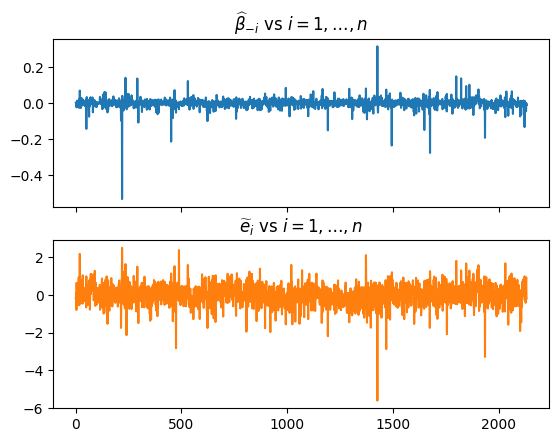

In [20]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2)
axs[0].plot(np.linspace(1,e_tilde.size,num=e_tilde.size).astype(int), bi[:,1])
axs[0].set_title(r'$\widehat{\beta}_{-i}$ vs $i=1,\ldots,n$')
axs[1].plot(np.linspace(1,e_tilde.size,num=e_tilde.size).astype(int), e_tilde,'tab:orange')
axs[1].set_title(r'$\widetilde{e}_{i}$ vs $i=1,\ldots,n$')
# Hide x labels and tick labels for top plots
for ax in axs.flat:
    ax.label_outer()

The '*prediction standard error*' is:

In [21]:
print(np.sqrt(np.mean(e_tilde**2)))

0.5412822771345772


## Residuals

In [22]:
residuos = pd.DataFrame({'e_hat': fit.resid, 'e_tilde': e_tilde, 'e_bar': fit.resid/np.sqrt(1-hii)})
print(residuos)

          e_hat   e_tilde     e_bar
149   -0.169630 -0.169892 -0.169761
156   -0.123202 -0.123369 -0.123285
403    0.092012  0.092113  0.092063
408   -0.797985 -0.798834 -0.798409
433    0.639162  0.640033  0.639597
...         ...       ...       ...
50701  0.021207  0.021236  0.021222
50721  0.789192  0.790566  0.789878
50723  0.928002  0.928765  0.928383
50725 -0.131072 -0.131185 -0.131129
50728 -0.186138 -0.186461 -0.186299

[2133 rows x 3 columns]


In [23]:
from pystata import stata
stata.pdataframe_to_data(residuos, force=True)
stata.run('summarize')


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
       e_hat |      2,133    1.30e-15    .5402701  -5.602127   2.459517
     e_tilde |      2,133    .0000735    .5414092   -5.61756   2.494832
       e_bar |      2,133    .0000364    .5408379  -5.609838   2.477112


## Covariance Matrix Estimation

**<span style="color:red">Homoskedasticity:</span>**

$$
\widehat{\mathbf{V}}_{\widehat{\beta}}^{0}=\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1} s^{2}
$$

In [24]:
print(fit.cov_params())

            Intercept     education    experience      exp2
Intercept    0.007564 -3.372091e-04 -1.903405e-04  0.000279
education   -0.000337  2.150172e-05  4.161708e-07  0.000003
experience  -0.000190  4.161708e-07  1.742673e-05 -0.000034
exp2         0.000279  2.890836e-06 -3.352658e-05  0.000070


In [25]:
from pystata import stata
stata.pdataframe_to_data(cps09mr, force=True)
stata.run('''
qui reg wage education experience exp2 if mnwf==1
''',quietly=True)
stata.run('matrix list e(V)')



symmetric e(V)[4,4]
             education  experience        exp2       _cons
 education    .0000215
experience   4.162e-07   .00001743
      exp2   2.891e-06  -.00003353   .00006978
     _cons  -.00033721  -.00019034   .00027868    .0075637


**<span style="color:red">HC0:</span>**

$$
\widehat{\mathbf{V}}_{\widehat{\beta}}^{\mathrm{HC0}}=\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}\left(\sum_{i=1}^{n} X_{i} X_{i}^{\prime}\widehat{e}_{i}^{2} \right)\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}
$$

In [26]:
print(fit.cov_HC0)

[[ 1.10361051e-02 -5.22891570e-04 -2.53592430e-04  3.81219025e-04]
 [-5.22891570e-04  3.13965326e-05  4.04430096e-06 -3.38449216e-06]
 [-2.53592430e-04  4.04430096e-06  1.79086564e-05 -3.35259797e-05]
 [ 3.81219025e-04 -3.38449216e-06 -3.35259797e-05  6.77948740e-05]]


**<span style="color:red">HC1:</span>** (most common in *econometrics*)

$$
\widehat{\mathbf{V}}_{\widehat{\beta}}^{\mathrm{HCl}}=\left(\frac{n}{n-k}\right)\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}\left(\sum_{i=1}^{n} X_{i} X_{i}^{\prime}\widehat{e}_{i}^{2} \right)\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}
$$


In [27]:
print(fit.cov_HC1)

[[ 1.10568400e-02 -5.23873987e-04 -2.54068884e-04  3.81935265e-04]
 [-5.23873987e-04  3.14555210e-05  4.05189946e-06 -3.39085100e-06]
 [-2.54068884e-04  4.05189946e-06  1.79423035e-05 -3.35889688e-05]
 [ 3.81935265e-04 -3.39085100e-06 -3.35889688e-05  6.79222481e-05]]


In [28]:
stata.run('''
qui reg wage education experience exp2 if mnwf==1, robust
''',quietly=True)
stata.run('matrix list e(V)')



symmetric e(V)[4,4]
             education  experience        exp2       _cons
 education   .00003146
experience   4.052e-06   .00001794
      exp2  -3.391e-06  -.00003359   .00006792
     _cons  -.00052387  -.00025407   .00038194   .01105684


**<span style="color:red">HC2:</span>**

$$
\widehat{\mathbf{V}}_{\widehat{\beta}}^{\mathrm{HC2}}=\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}\left(\sum_{i=1}^{n} \left(1-h_{i i}\right)^{-1} X_{i}X_{i}^{\prime}\widehat{e}_{i}^{2} \right)\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}
$$

In [29]:
print(fit.cov_HC2)

[[ 1.11236454e-02 -5.26912800e-04 -2.56341144e-04  3.86741144e-04]
 [-5.26912800e-04  3.16232376e-05  4.10639944e-06 -3.49933778e-06]
 [-2.56341144e-04  4.10639944e-06  1.81038668e-05 -3.39468714e-05]
 [ 3.86741144e-04 -3.49933778e-06 -3.39468714e-05  6.87216398e-05]]


In [30]:
stata.run('''
qui reg wage education experience exp2 if mnwf==1, vce(hc2)
''',quietly=True)
stata.run('matrix list e(V)')



symmetric e(V)[4,4]
             education  experience        exp2       _cons
 education   .00003162
experience   4.106e-06    .0000181
      exp2  -3.499e-06  -.00003395   .00006872
     _cons  -.00052691  -.00025634   .00038674   .01112365


**<span style="color:red">HC3:</span>**

$$
\widehat{\mathbf{V}}_{\widehat{\beta}}^{\mathrm{HC3}}=\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}\left(\sum_{i=1}^{n}  \left(1-h_{i i}\right)^{-2}X_{i}X_{i}^{\prime}\widehat{e}_{i}^{2}  \right)\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1}
$$

In [31]:
print(fit.cov_HC3)

[[ 1.12135844e-02 -5.31022229e-04 -2.59211496e-04  3.92529826e-04]
 [-5.31022229e-04  3.18538582e-05  4.17178950e-06 -3.62127186e-06]
 [-2.59211496e-04  4.17178950e-06  1.83073675e-05 -3.43862068e-05]
 [ 3.92529826e-04 -3.62127186e-06 -3.43862068e-05  6.96895317e-05]]


In [32]:
stata.run('''
qui reg wage education experience exp2 if mnwf==1, vce(hc3)
''',quietly=True)
stata.run('matrix list e(V)')



symmetric e(V)[4,4]
             education  experience        exp2       _cons
 education   .00003185
experience   4.172e-06   .00001831
      exp2  -3.621e-06  -.00003439   .00006969
     _cons  -.00053102  -.00025921   .00039253   .01121358


## Standard Errors

**<span style="color:red">Homoskedasticity:</span>**

In [33]:
print(fit.bse)

Intercept     0.086970
education     0.004637
experience    0.004175
exp2          0.008353
dtype: float64


**<span style="color:red">HC0:</span>**

In [34]:
print(fit.HC0_se)

Intercept     0.105053
education     0.005603
experience    0.004232
exp2          0.008234
dtype: float64


**<span style="color:red">HC1:</span>**

In [35]:
print(fit.HC1_se)

Intercept     0.105152
education     0.005609
experience    0.004236
exp2          0.008241
dtype: float64


**<span style="color:red">HC2:</span>**

In [36]:
print(fit.HC2_se)

Intercept     0.105469
education     0.005623
experience    0.004255
exp2          0.008290
dtype: float64


**<span style="color:red">HC3:</span>**

In [37]:
print(fit.HC3_se)

Intercept     0.105894
education     0.005644
experience    0.004279
exp2          0.008348
dtype: float64


## Measures of Fit

**<span style="color:red">R-squared:</span>**
$$
R^{2}=1-\frac{\sum_{i=1}^{n} \widehat{e}_{i}^{2}}{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}}
$$

In [38]:
print(fit.rsquared)

0.24193567211217404


In [39]:
from sfi import Scalar
rsquared=Scalar.getValue('e(r2)')
print(rsquared)

0.24193567211217348


**<span style="color:red">Adjusted R-squared:</span>**

$$
\bar{R}^{2}=1-\frac{(n-1) \sum_{i=1}^{n} \hat{e}_{i}^{2}}{(n-k) \sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}}
$$

In [40]:
print(fit.rsquared_adj)

0.2408674743744269


In [41]:
radj=Scalar.getValue('e(r2_a)')
print(radj)

0.24086747437442646


**<span style="color:red">(Alternative) R-squared:</span>**

$$
\widetilde{R}^{2}=1-\frac{\sum_{i=1}^{n} \widetilde{e}_{i}^{2}}{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}}
$$

In [42]:
from statsmodels.stats.outliers_influence import OLSInfluence
R2_tilde = 1 - (OLSInfluence(fit).resid_press**2).sum()/fit.centered_tss
print(R2_tilde)

0.2387356065956785
